Goal is to complete the "Further Research" project: 

> Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

In [113]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

First change: need to use the full MNIST dataset. Not just the sample that only has 3's and 7's. 

In [114]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [115]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [116]:
(path/'training').ls()

(#10) [Path('training/9'),Path('training/3'),Path('training/6'),Path('training/0'),Path('training/7'),Path('training/2'),Path('training/4'),Path('training/8'),Path('training/5'),Path('training/1')]

As expected, a directory for every digit.

Let's confirm it's the same number of pixels as from the sample dataset.

In [117]:
im1_path = (path/'training/1').ls().sorted()[0]
im1 = Image.open(im1_path)
im1

In [118]:
tensor(im1).shape

torch.Size([28, 28])

Good

### Approach for handling categorical values

The first big question to answer is how we're going to encode the labels. For 3 vs. 7, it is straightforward: 1 is 3, 0 is 7. 

For classifying each of the 10 digits, it's a bit more complex. 

The naive way would be to have the model output a number. The loss would be the distance from the prediction to the label. And the accuracy would be measured as the % of times the model's prediction was closest to the label. 

The issue with this approach is that it treats the labels as continuous values, when they are categorical/discrete values. For example, any given 1 and 9 are more similar to each other than any given 1 and 8. 

However, this method of measuring loss would treat a 9 prediction as further from the 1 label as an 8 prediction, which doesn't seem correct. Also, relatedly, it doesn't allow the model to be able to express a confidence in a particular number, it is forced to make one scalar prediction which encodes false assumptions about digit similarity (as described above).

Instead, what we must do is treat each label as discrete and unrelated. So a "1" prediction isn't inherently closer to a "2". The closeness must depend on the model's prediction for a particular example, and not based on how we construct the space of labels. 

The correct way to handle categorical labels is to use 'one-hot encoding', where the model outputs a prediction quantity for each of the 10 possible digits. Each digit label is encoded as nine 0's with one 1 corresponding to the actual label. Then, we measure accuracy as the number of times the model's most confident prediction is the correct label, and we encode loss as the distance between the model's prediction for the correct label. The prediction should correspond to the _probability_ or _confidence_ that that particular digit is what's being represented.

In [119]:
possible_labels = F.one_hot(torch.arange(0, 10))

We need to arrange this so that:

the first row: `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is the label for 0

the second row: `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]` is the label for 1

etc

In the MNIST_SAMPLE, we had a line like this: 

`train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)`

We'll try something where instead of `[1]` meaning 3, we'll instead of `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]` means 3.

We also need to set up `train_x` so it includes data for each possible digit, rather than having the code for 3 and 7 be copied. Let's try it!

In [120]:
# train_x should ultimately have a similar shape as in mnist_sample:
# (<num_images>, 784)
# train_y should have a slightly different shape:
# - each element should be a list (rather than a one element tensor)
def compute_dset(mode='training'):
    allowed_modes = {'training', 'testing'} 
    if mode not in allowed_modes:
        raise Exception(f'path must be in {allowed_modes}')

    x = []
    stacked_tensors = []
    y = []
    for digit in range(0, 10):
        print(mode, digit)
        digit_paths = (path/f'{mode}/{digit}').ls().sorted()
        digit_tensors = [tensor(Image.open(o)) for o in digit_paths]
        stacked_digit = torch.stack(digit_tensors).float()/255
        stacked_tensors.append(stacked_digit)
        y += [possible_labels[digit]]*len(digit_paths)
    x = torch.cat(stacked_tensors).view(-1, 28*28)
    dset = list(zip(x, y))
    return dset

batch_size = 256
train_dset = compute_dset(mode='training')
train_dl = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_dset = compute_dset(mode='testing')
valid_dl = DataLoader(valid_dset, batch_size=batch_size, shuffle=True)

training 0
training 1
training 2
training 3
training 4
training 5
training 6
training 7
training 8
training 9
testing 0
testing 1
testing 2
testing 3
testing 4
testing 5
testing 6
testing 7
testing 8
testing 9


In [121]:
x, y = train_dset[0]
x, y
x.shape, y

(torch.Size([784]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

This is inline with what we want (I think). 

Input is 784 pixels, output is a list of 10 possible values, one-hot encoded.

Now, let's construct the model. 

The model must output 10 predictions. Each of those 10 predictions should align with the likelihood of that particular digit. 

Below:
- n_out1 is the output from the first linear layer. This is arbitrary and I'll tweak it to get better model performance. 
- nn.Linear must output 10 predictions, each corresponding to a digit. 
- I then need to run these through the `softmax` function so it converts the predictions to what they need to be: relative probabilities that sum to 1 (as probabilities should)

In [122]:
n_out1 = 30 
model = nn.Sequential(
    nn.Linear(28*28,n_out1),
    nn.ReLU(),
    nn.Linear(n_out1,10)  # 10 output channels
)

Let's see how to get a singular prediction out of the model to verify: 
- what a set of predictions looks like
- how to softmax those predictions

<Axes: >

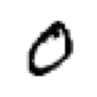

In [123]:
show_image(x.view(28, 28))

In [124]:
pred = model(x)
pred

tensor([ 0.0299, -0.0734,  0.1766, -0.0362, -0.0795,  0.0382,  0.0314, -0.0877, -0.0388, -0.0339], grad_fn=<ViewBackward0>)

In [125]:
test = tensor([11, 2, 3], [4, 5, 6], [7, 8, 9])
softmaxxed = F.softmax(test.float())
softmaxxed

/tmp/ipykernel_2746/4116768088.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxxed = F.softmax(test.float())


tensor([[9.9954e-01, 1.2335e-04, 3.3531e-04],
        [9.0031e-02, 2.4473e-01, 6.6524e-01],
        [9.0031e-02, 2.4473e-01, 6.6524e-01]])

So far so good. 

Now, let's ensure we can take a softmax on a tensor of predictions, since our `mnist_loss` is going to feed a minibatch's worth of predictions to the loss function, and this is where we must softmax.

This clarifies the first part of the mnist_loss function - how to take the softmax. 

Now that the predictions are appropriately softmaxxed - how do we compute a suitable loss?

One idea is to just take the mean difference between the correct label (i.e, the singular `1` in the array), and the corresponding probability of that digit for row of the minibatch.

To do that, I need to be able to access the `index` of the 1 in the target, and then use that index to access the prediction quantity in the prediction tensor, and then take the mean of 1 minus that value. Let's do this using `argmax` and let's see how it works.

In [126]:
torch.argmax(test, axis=1)

tensor([0, 2, 2])

In [127]:
def mnist_loss(predictions, targets):
    predictions = F.softmax(predictions)
    index_of_1 = torch.argmax(targets, axis=1)
    loss = (1 - predictions[torch.arange(len(predictions)), index_of_1])
    return loss.mean()

Similar task to compute accuracy: compare whether argmax of predictions equals argmax of actuals. 

In [128]:
def batch_accuracy(model_preds, yb):
    most_likely_pred = torch.argmax(model_preds, axis=1)
    correct_ans = torch.argmax(yb, axis=1)
    return (most_likely_pred == correct_ans).sum() / len(model_preds) 

In [129]:
dls = DataLoaders(train_dl, valid_dl)

In [130]:
learn = Learner(dls, model, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
lr = 0.1
learn.fit(40, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.744367,0.670682,0.452000,00:03
1,0.429554,0.393185,0.656300,00:04
2,0.341814,0.313278,0.741100,00:04
3,0.244871,0.222805,0.830200,00:05
4,0.183521,0.163355,0.887200,00:05
5,0.152111,0.140334,0.895000,00:04
6,0.136489,0.128365,0.899400,00:04
7,0.129734,0.120194,0.904300,00:04
8,0.120931,0.113949,0.908100,00:04
9,0.114008,0.109864,0.910400,00:04


/tmp/ipykernel_2746/575856330.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = F.softmax(predictions)


So, high level, this works! Gets to around 93% accuracy a nd tops out.